In [25]:
import collections
import math
import os
import random
import zipfile
import numpy as np
import urllib 
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# load data

In [5]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urllib.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + \
                        '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

('Found and verified', 'text8.zip')


# read data

In [6]:
def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data Size', len(words))

('Data Size', 17005207)


# build vocabulary list

In [7]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data,count, dictionary, reverse_dictionary = build_dataset(words)

# del raw words list and release memory

In [8]:
del words
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156], ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against'])


In [12]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    # read span-num words into buffer
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

# test generate_batch function

In [13]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
         reverse_dictionary[labels[i, 0]])

(3084, 'originated', '->', 12, 'as')
(3084, 'originated', '->', 5239, 'anarchism')
(12, 'as', '->', 6, 'a')
(12, 'as', '->', 3084, 'originated')
(6, 'a', '->', 12, 'as')
(6, 'a', '->', 195, 'term')
(195, 'term', '->', 6, 'a')
(195, 'term', '->', 2, 'of')


# define training parameters

In [16]:
batch_size = 128
# dimension of word to dense embedding
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
# negative noise samples
num_sampled = 64

# define skip-gram word2vec

In [23]:
graph = tf.Graph()
with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform(
        [vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    nce_weights = tf.Variable(tf.truncated_normal(
        [vocabulary_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    # loss
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                        biases=nce_biases,
                                        labels=train_labels,
                                        inputs=embed,
                                        num_sampled=num_sampled,
                                        num_classes=vocabulary_size))
    
    # sgd optimizer
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # normalization
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    # initialization
    init = tf.global_variables_initializer()

# train

In [24]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')
    
    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # avg loss
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print avg loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
        # print similarity and nearest word
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
('Average loss at step ', 0, ': ', 283.73907470703125)
Nearest to his: froze, schwarz, alkoxide, silver, clad, wrestlemania, dreamer, hostages,
Nearest to between: homeostatic, bastille, kabir, antithetical, hiroshi, olds, ugric, manipulation,
Nearest to will: dice, auditioning, optimize, blameless, primed, reagan, asb, larynx,
Nearest to i: referees, topological, bicycles, inhibitors, sterne, onward, juanita, mackinac,
Nearest to zero: blackberry, scrambled, caliph, neodymium, oakley, perpendicular, dawning, disregarding,
Nearest to on: increment, cayce, kinematic, lateral, approximations, secondo, fein, mali,
Nearest to more: kurosawa, barometer, trachea, paine, cathy, armchair, renovation, sombre,
Nearest to th: gregor, annually, incited, brooke, implementing, redirected, blowing, cassian,
Nearest to some: slated, rumour, discriminant, hypoglycemic, supermodel, regularly, intermarriages, backstreet,
Nearest to are: bnetd, weaken, kemp, cellini, bertha, itinerant, baur, c

('Average loss at step ', 52000, ': ', 5.1600726602077485)
('Average loss at step ', 54000, ': ', 5.0917941220998761)
('Average loss at step ', 56000, ': ', 5.0701357588768001)
('Average loss at step ', 58000, ': ', 5.08545918238163)
('Average loss at step ', 60000, ': ', 4.953839257538319)
Nearest to his: their, its, her, the, s, thibetanus, dasyprocta, possesses,
Nearest to between: in, with, hbox, cebus, callisto, bastille, partner, from,
Nearest to will: would, can, should, may, could, to, abet, layers,
Nearest to i: callithrix, we, ii, syndromes, indira, they, ramps, joint,
Nearest to zero: eight, six, seven, five, nine, four, three, dasyprocta,
Nearest to on: in, at, gaians, and, define, reginae, during, caterpillars,
Nearest to more: kurosawa, less, wct, gland, contaminated, most, very, linebackers,
Nearest to th: seven, eight, six, implementing, zero, five, nine, meanwhile,
Nearest to some: many, these, both, the, agouti, dasyprocta, this, voortrekkers,
Nearest to are: were, is

# 2d plot function

In [32]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
        
    plt.savefig(filename)
    plt.show()

# dimension reduction

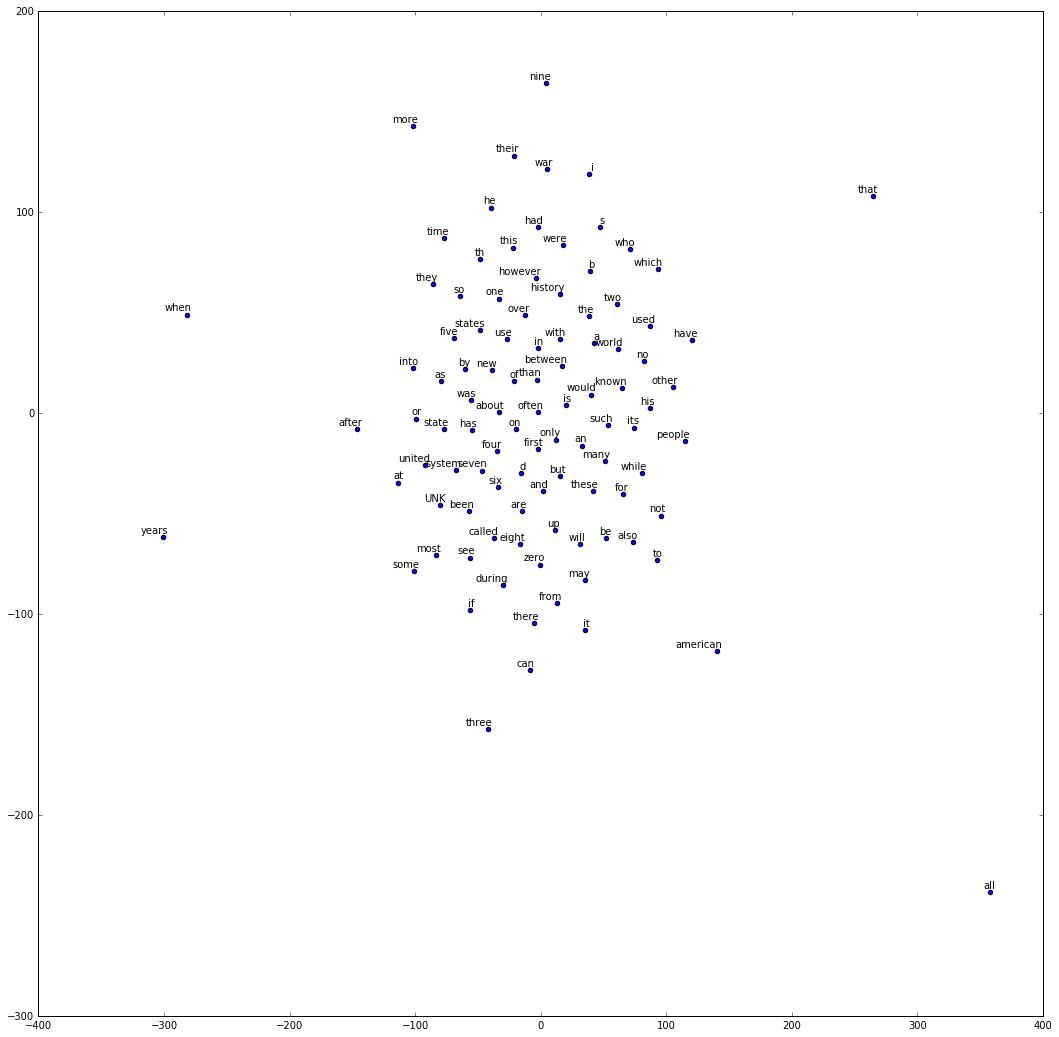

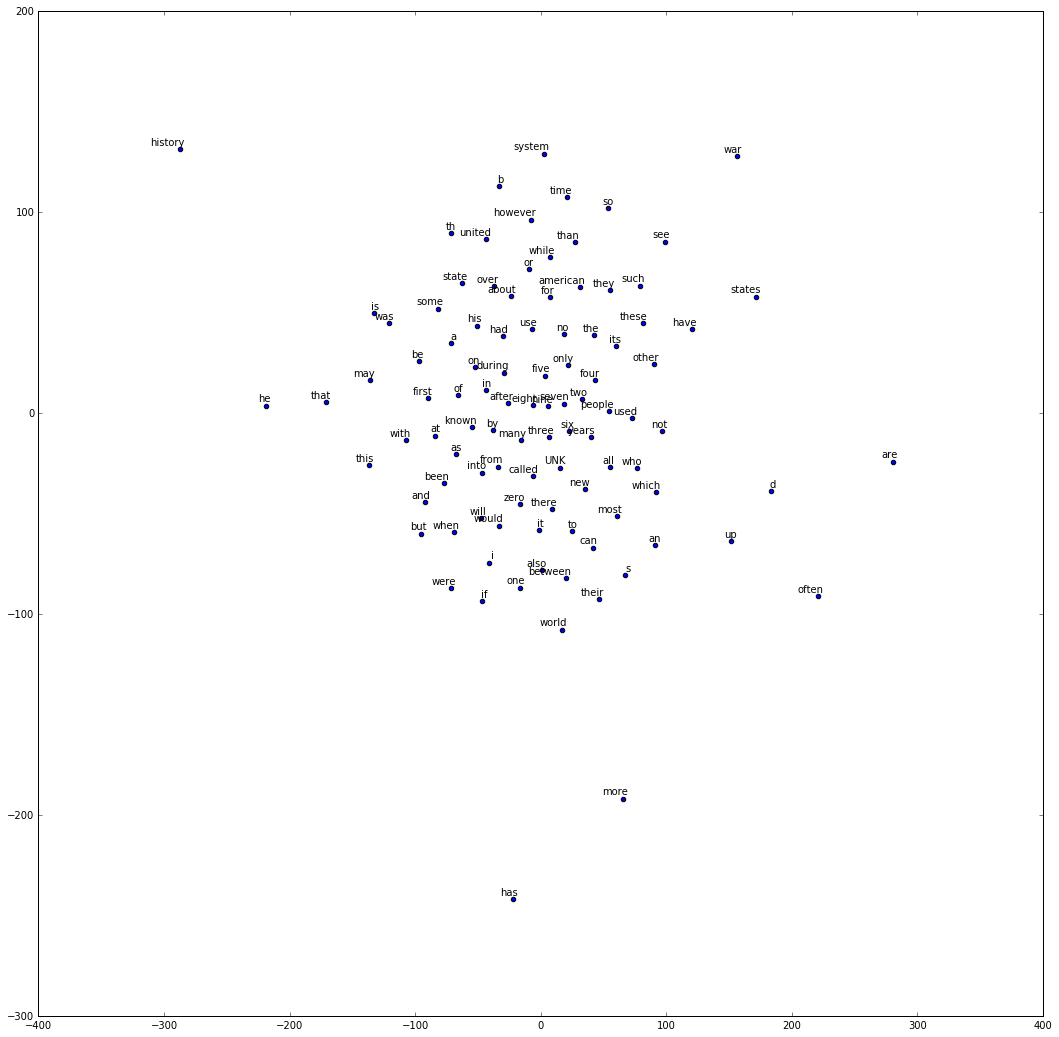

In [33]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)